In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
conn = sqlite3.connect('iotaDB.db')
import numpy as np
import json

Calculates the wealth of each adress by adding the output amount and substracting the input amount of each transactions to its corresponding addresses.

In [2]:
import sqlite3
import json
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')
cursor = conn.cursor()

# Query the database for the JSON strings of addresses and amounts
cursor.execute("SELECT input_addresses_x, input_amounts_x, output_addresses_y, output_amounts_y FROM Transactions")
rows = cursor.fetchall()

# Dictionary to hold the net amounts for each address (outputs - inputs)
address_balances = {}

# Function to update address balances based on inputs or outputs
def update_balances(addresses, amounts, is_input=True):
    for address, amount in zip(addresses, amounts):
        if address in address_balances:
            address_balances[address] += (-amount if is_input else amount)
        else:
            address_balances[address] = (-amount if is_input else amount)

# Iterate over each row to parse JSON and accumulate amounts
for input_addresses_x, input_amounts_x, output_addresses_y, output_amounts_y in rows:
    # Parse the JSON data
    input_addresses = json.loads(input_addresses_x)
    input_amounts = json.loads(input_amounts_x)
    output_addresses = json.loads(output_addresses_y)
    output_amounts = json.loads(output_amounts_y)
    
    # Update balances for input and output addresses
    update_balances(input_addresses, input_amounts, is_input=True)
    update_balances(output_addresses, output_amounts, is_input=False)

# Close the database connection
conn.close()




# Plotting the top 10 adresses

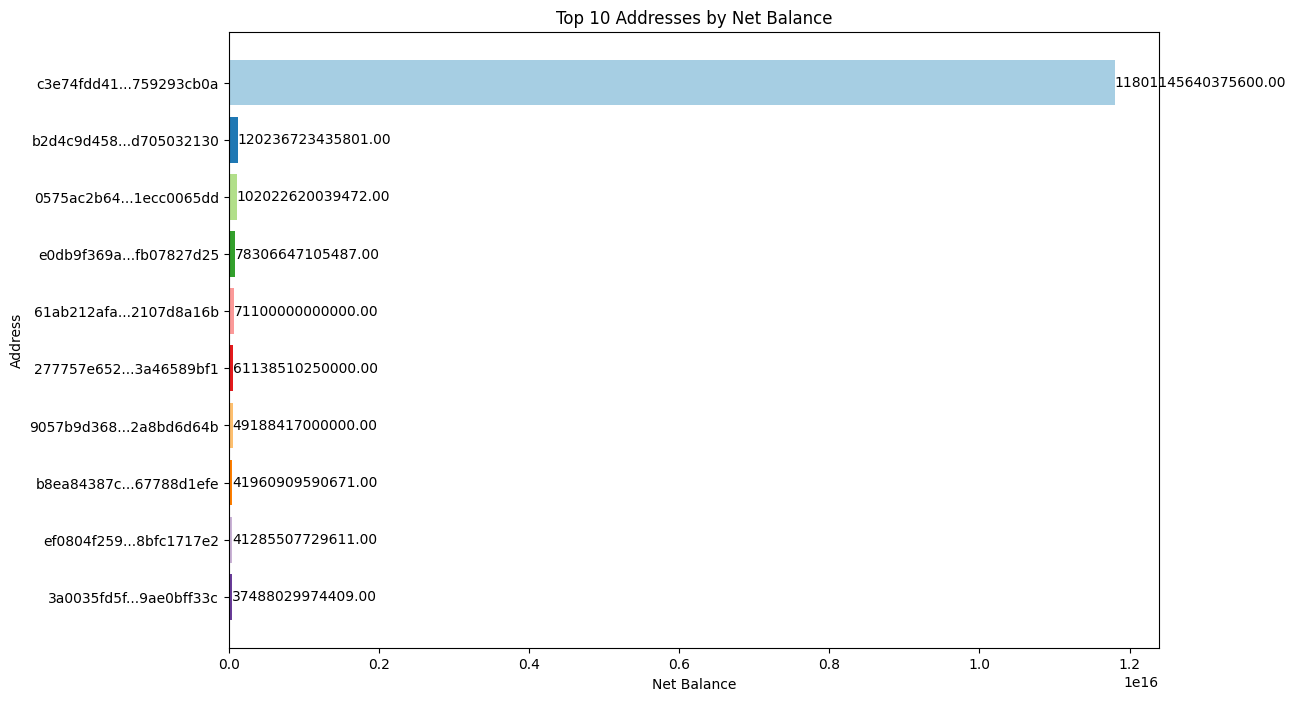

In [3]:
# Create a DataFrame from the address balances
df = pd.DataFrame(list(address_balances.items()), columns=['Address', 'Net Balance'])

# Sort by 'Net Balance' in descending order and pick the top ten
top_ten_df = df.sort_values(by='Net Balance', ascending=False).head(10)

# Shorten the address for display purposes
top_ten_df['Short Address'] = top_ten_df['Address'].apply(lambda x: f'{x[:10]}...{x[-10:]}')

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.barh(top_ten_df['Short Address'], top_ten_df['Net Balance'], color=plt.cm.Paired(range(len(top_ten_df))))
plt.xlabel('Net Balance')
plt.ylabel('Address')
plt.title('Top 10 Addresses by Net Balance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top

# Add labels to the bars
for bar in bars:
    plt.gca().text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

plt.show()

# Identifying the total values and seperating them in (negative, zero, positive) values

In [3]:
# Calculate the number of addresses with negative, zero, and positive balances
negative_balance_count = sum(1 for balance in address_balances.values() if balance < 0)
zero_balance_count = sum(1 for balance in address_balances.values() if balance == 0)
positive_balance_count = sum(1 for balance in address_balances.values() if balance > 0)
total_addresses = len(address_balances)


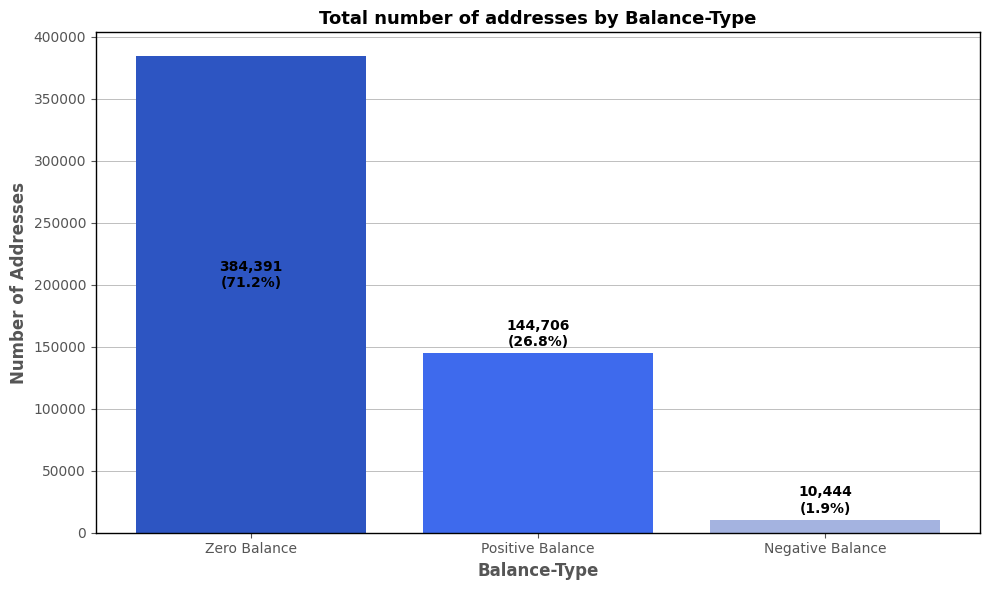

In [4]:
import matplotlib.pyplot as plt
import seaborn as se


total_addresses = negative_balance_count + zero_balance_count + positive_balance_count
# Data for the bar chart
labels = ['Zero Balance','Positive Balance','Negative Balance' ]
counts = [zero_balance_count,  positive_balance_count, negative_balance_count]
colors = ['#2d55c2', '#3e6aed', '#a4b3e0']  # Darker colors
percentages = [count / total_addresses * 100 for count in counts]



# Use the 'ggplot' style for a professional look
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(labels, counts, color=colors)

# Adding annotations
for bar, count, percentage in zip(bars, counts, percentages):
    height = bar.get_height()
    if count == zero_balance_count:  # Adjust position for zero balance bar
        ax.annotate(f'{count:,}\n({percentage:.1f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    else:
        ax.annotate(f'{count:,}\n({percentage:.1f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding labels and title 
ax.set_xlabel('Balance-Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Addresses', fontsize=12, fontweight='bold')
ax.set_title('Total number of addresses by Balance-Type', fontsize=13, fontweight='bold')

#Raster
ax.grid(True, which='major', axis= 'y', linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
ax.set_facecolor('white') 

# Adding a border around the plot area
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)


plt.tight_layout()
plt.show()

# Creating a Table for storing the addresses with its netbalance

In [5]:
import sqlite3
import json

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')
cursor = conn.cursor()

# Create the table (only need to run this once)
cursor.execute("""
CREATE TABLE IF NOT EXISTS AddressBalances (
    address TEXT PRIMARY KEY,
    balance REAL,
    last_updated DATETIME DEFAULT CURRENT_TIMESTAMP
)
""")

# Existing code to fetch transactions and calculate balances
# Make sure to include your existing transaction processing logic here

for address, balance in address_balances.items():
    # Update existing records
    cursor.execute("""
    UPDATE AddressBalances SET balance = ? WHERE address = ?;
    """, (balance, address))

    # Insert new record if it does not exist
    cursor.execute("""
    INSERT INTO AddressBalances (address, balance)
    SELECT ?, ?
    WHERE (Select Changes() = 0);
    """, (address, balance))




# Commit the changes and close the connection
conn.commit()


In [6]:
# Query the database and load data into a DataFrame
query = "SELECT address, balance FROM AddressBalances"
df = pd.read_sql_query(query, conn)

df.head()

,address,balance
0,704e8eccc32d7b314cc0cccbc29eaae59aa73c0880161d...,0.000000e+00
1,dea80a1c63c56f21beb18bae761b80d33fc0ad08ada018...,2.764507e+11
2,ef2e82cbdfb4cd7cff8c124deebe21774c860418b143eb...,0.000000e+00
3,1cfadd558641a3d501a4ea05e9ccc043d19180ac34ab19...,0.000000e+00
4,e319d445b5401cc40a3f86d739f1cf4faa3892891d228e...,0.000000e+00


In [7]:
import pandas as pd

# Annahme: Der DataFrame df ist bereits definiert und enthält die Daten

# Speichern des DataFrames in eine CSV-Datei
df.to_csv('address_balances.csv', index=False)

print("DataFrame wurde in address_balances.csv gespeichert")

DataFrame wurde in address_balances.csv gespeichert


# Handling negative values and 0 values

Number of addresses with a zero balance:

In [8]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('iotaDB.db')

# SQL query to count addresses with a zero balance
query = "SELECT COUNT(*) FROM AddressBalances WHERE balance = 0"
cursor = conn.cursor()
cursor.execute(query)
zero_balance_count = cursor.fetchone()[0]

# Close the connection
conn.close()

print(f"Number of addresses with a zero balance: {zero_balance_count}")

Number of addresses with a zero balance: 384391


Number of addresses with a negative balance

In [9]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('iotaDB.db')

# SQL query to count addresses with a negative balance
query = "SELECT COUNT(*) FROM AddressBalances WHERE balance < 0"
cursor = conn.cursor()
cursor.execute(query)
negative_balance_count = cursor.fetchone()[0]

# Close the connection
conn.close()

print(f"Number of addresses with a negative balance: {negative_balance_count}")

Number of addresses with a negative balance: 10444


Number of addresses

In [10]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('iotaDB.db')

# SQL query to count addresses with a zero balance
query = "SELECT COUNT(*) FROM AddressBalances address"
cursor = conn.cursor()
cursor.execute(query)
adress_count = cursor.fetchone()[0]

# Close the connection
conn.close()

print(f"Number of addresses: {adress_count}")

Number of addresses: 539541


In [12]:
# Connect to SQLite database
#conn = sqlite3.connect('iotaDB.db')

# SQL command to delete addresses with a zero balance
#query = "DELETE FROM AddressBalances WHERE balance = 0"
#cursor = conn.cursor()

# Execute the delete command
#cursor.execute(query)

# Commit the changes to the database
#conn.commit()

# Check how many rows were affected
#deleted_rows = cursor.rowcount

# Close the connection
#conn.close()

#print(f"Number of addresses deleted: {deleted_rows}")

In [13]:
# import sqlite3

# Connect to SQLite database
# conn = sqlite3.connect('iotaDB.db')

# SQL query to count addresses with a zero balance
# query = "SELECT COUNT(*) FROM AddressBalances address"
# cursor = conn.cursor()
# cursor.execute(query)
# adress_count = cursor.fetchone()[0]

# Close the connection
# conn.close()

# print(f"Number of addresses after eliminating zero_balance addresses: {adress_count}")

# Zero Value Analysis

Total Zero & NonZero Addresses

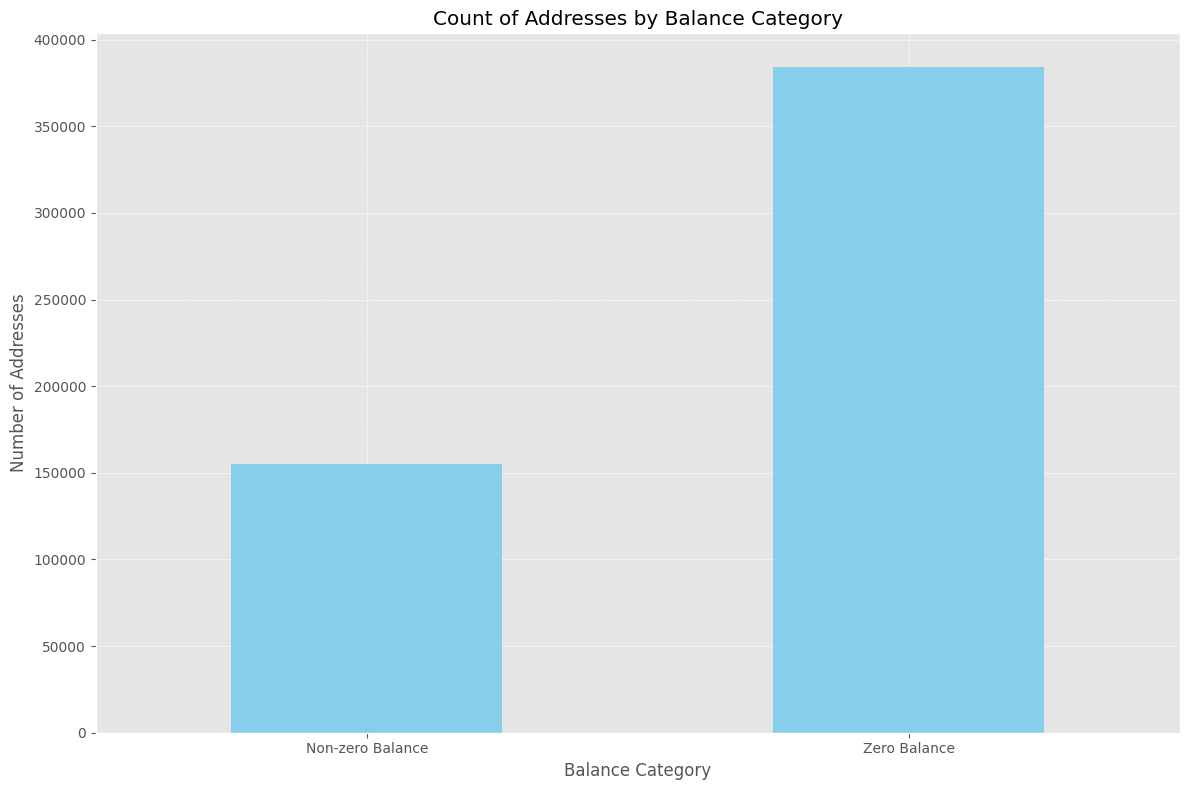

In [11]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Query to get the balance for each address
query = "SELECT balance, COUNT(address) as address_count FROM AddressBalances GROUP BY balance"
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Plot the data
plt.figure(figsize=(12, 8))

# Since there are likely many unique balances, we can visualize this with a scatter plot or bar plot for specific balances
# Convert balances to categories for better visualization: Non-zero vs. Zero
df['Balance Category'] = ['Zero Balance' if x == 0 else 'Non-zero Balance' for x in df['balance']]

# Group by the new category to sum up the addresses
category_counts = df.groupby('Balance Category')['address_count'].sum()

# Create the plot
category_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Addresses by Balance Category')
plt.xlabel('Balance Category')
plt.ylabel('Number of Addresses')
plt.xticks(rotation=0)  # Horizontal x-axis labels for clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [12]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json

# Connect to the SQLite database
conn = sqlite3.connect('iotaDB.db')

# Fetch all transaction input and output data
query = """
SELECT input_addresses_x, input_amounts_x, output_addresses_y, output_amounts_y
FROM Transactions
"""
transactions = pd.read_sql_query(query, conn)
conn.close()

# Function to parse transaction lists stored as strings
def parse_transaction_data(data):
    return json.loads(data.replace('\'', '\"'))

# Convert data columns from JSON strings to lists
transactions['input_addresses_x'] = transactions['input_addresses_x'].apply(parse_transaction_data)
transactions['input_amounts_x'] = transactions['input_amounts_x'].apply(parse_transaction_data)
transactions['output_addresses_y'] = transactions['output_addresses_y'].apply(parse_transaction_data)
transactions['output_amounts_y'] = transactions['output_amounts_y'].apply(parse_transaction_data)

# Initialize dictionaries to track net balances, incoming and outgoing transaction counts
net_balances = {}
outgoing_transaction_counts = {}
incoming_transaction_counts = {}

# Process each transaction to update net balances and count transactions
for _, row in transactions.iterrows():
    # Handle inputs (spending, thus subtracting balances)
    for address, amount in zip(row['input_addresses_x'], row['input_amounts_x']):
        if address not in net_balances:
            net_balances[address] = 0
            outgoing_transaction_counts[address] = 0
            incoming_transaction_counts[address] = 0
        net_balances[address] -= amount
        outgoing_transaction_counts[address] += 1
    
    # Handle outputs (receiving, thus adding balances)
    for address, amount in zip(row['output_addresses_y'], row['output_amounts_y']):
        if address not in net_balances:
            net_balances[address] = 0
            outgoing_transaction_counts[address] = 0
            incoming_transaction_counts[address] = 0
        net_balances[address] += amount
        incoming_transaction_counts[address] += 1

# Calculate total addresses with zero balance
total_zero_balances = 0

for address, balance in net_balances.items():
    if balance == 0:
        total_zero_balances +=1

#total_zero_balances = sum(1 for balance in net_balances.values() if balance == 0)

# Count addresses with zero balance after exactly one incoming and one outgoing transaction
one_in_one_out_zero_balances = sum(1 for addr in net_balances if incoming_transaction_counts.get(addr, 0) == 1 and outgoing_transaction_counts.get(addr, 0) == 1 and net_balances.get(addr, 0) == 0)



Percentage of the total Zero Balance Addresses

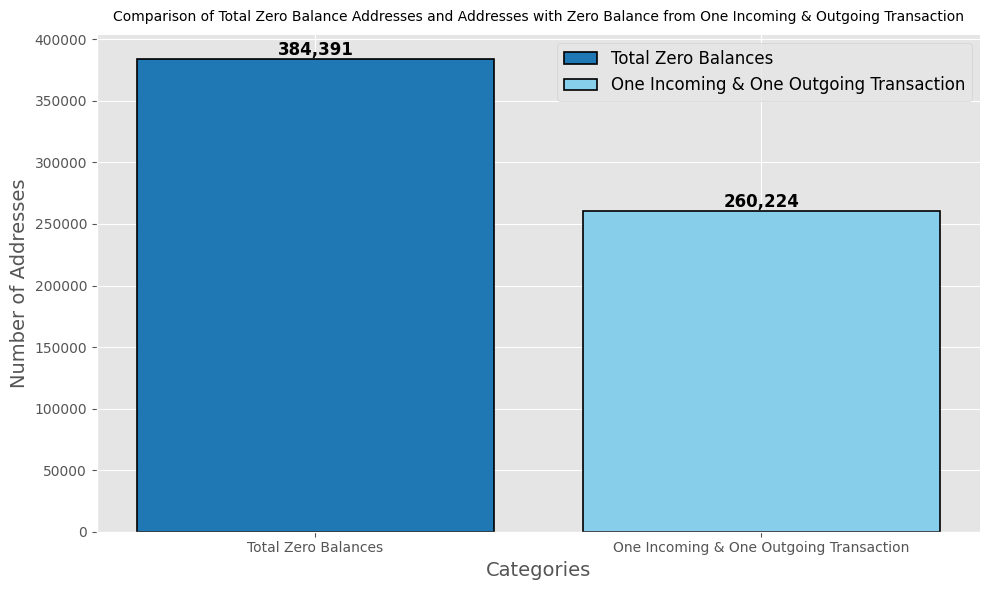

Total addresses with zero balance: 384391
Addresses with zero balance after one incoming and one outgoing transaction: 260224


In [13]:
# Plot the result using a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Data
categories = ['Total Zero Balances', 'One Incoming & One Outgoing Transaction']
values = [total_zero_balances, one_in_one_out_zero_balances]
colors = ['#1f77b4', 'skyblue']

# Plotting
bars = ax.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Add text annotation directly above the bars for clearer communication
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Title and labels
ax.set_title('Comparison of Total Zero Balance Addresses and Addresses with Zero Balance from One Incoming & Outgoing Transaction', fontsize=10, pad=10)
ax.set_ylabel('Number of Addresses', fontsize=14)
ax.set_xlabel('Categories', fontsize=14)
ax.yaxis.grid(True, which='minor', linestyle='--', linewidth='0.7', color='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding a legend
legend_labels = ['Total Zero Balances', 'One Incoming & One Outgoing Transaction']
ax.legend(bars, legend_labels, fontsize=12)

# Apply tight layout
plt.tight_layout()

# Show plot
plt.show()

# Output the result
print(f"Total addresses with zero balance: {total_zero_balances}")
print(f"Addresses with zero balance after one incoming and one outgoing transaction: {one_in_one_out_zero_balances}")


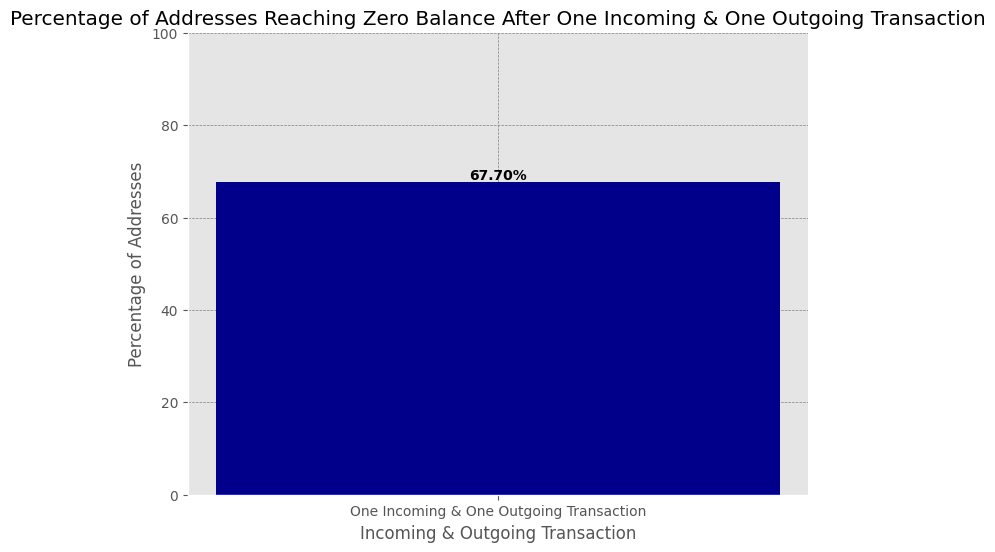

In [14]:
import matplotlib.pyplot as plt

# Calculate the percentage
percentage_one_in_one_out = (one_in_one_out_zero_balances / total_zero_balances) * 100

# Plotting the percentage
plt.figure(figsize=(8, 6))
plt.bar(['One Incoming & One Outgoing Transaction'], [percentage_one_in_one_out], color='darkblue')

# Add text annotation directly above the bar for clearer communication
plt.text(0, percentage_one_in_one_out, f'{percentage_one_in_one_out:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.title('Percentage of Addresses Reaching Zero Balance After One Incoming & One Outgoing Transaction')
plt.ylabel('Percentage of Addresses')
plt.ylim(0, 100)  # Percentage scale from 0 to 100

plt.xlabel('Incoming & Outgoing Transaction')

# Improve style
plt.style.use('ggplot')
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

# Negative Balance Analysis

In [15]:
total_negative_amount = sum(balance for balance in address_balances.values() if balance < 0)
total_positive_amount = sum(balance for balance in address_balances.values() if balance > 0)
absolute_value = total_positive_amount - total_negative_amount

# Print summary of findings
print(f"Total negative amount: {total_negative_amount}")
print(f"Total positive amount: {total_positive_amount}")
print(f"Absolut: {absolute_value}")

# Identify addresses with negative balances
negative_balances = {address: balance for address, balance in address_balances.items() if balance < 0}

# Print summary of findings
print(f"Number of addresses with negative balances: {len(negative_balances)}")


Total negative amount: -304874545386495.0
Total positive amount: 1.4274909361700276e+16
Absolut: 1.4579783907086772e+16
Number of addresses with negative balances: 10444


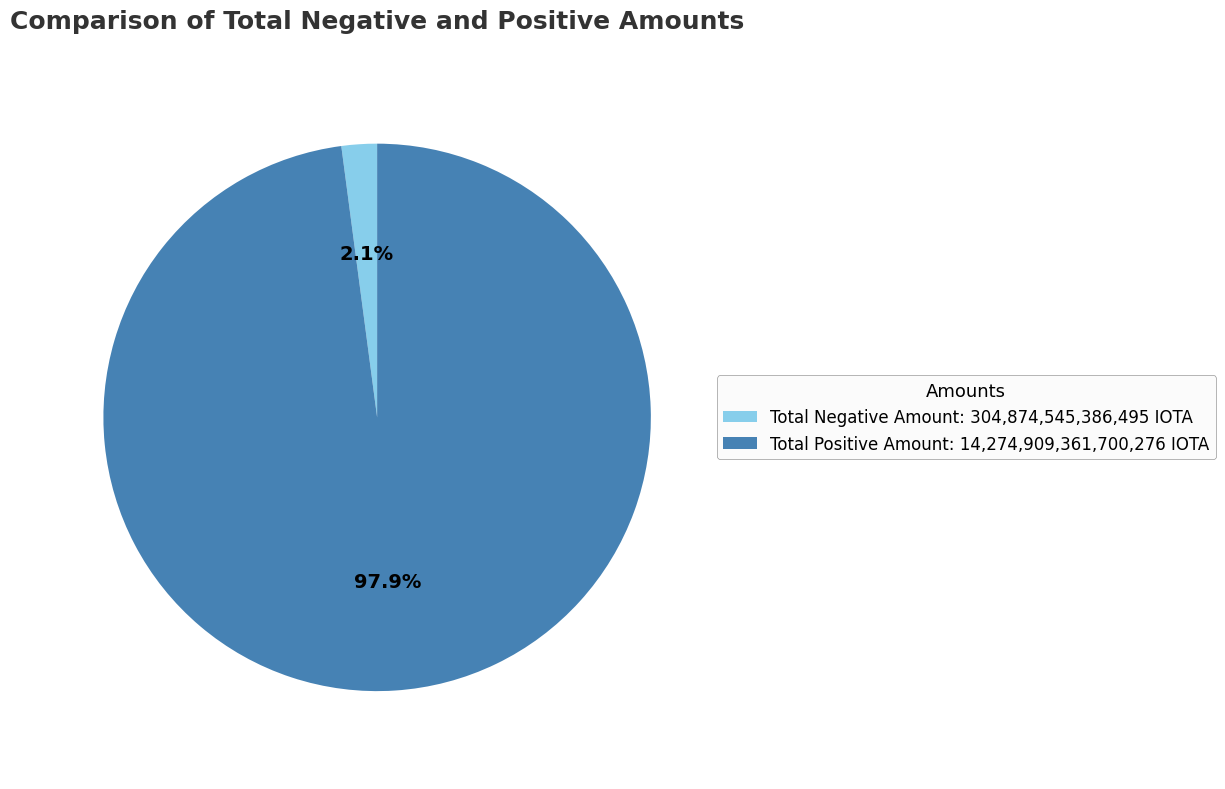

In [16]:
import matplotlib.pyplot as plt

# Data for the pie chart
total_negative_amount = 304874545386495.0
total_positive_amount = 1.4274909361700276e+16
amounts = [abs(total_negative_amount), total_positive_amount]
labels = ['', '']
colors = ['#87CEEB', '#4682B4']  

# Plotting the pie chart
fig, ax = plt.subplots(figsize=(12, 8))  
wedges, texts, autotexts = ax.pie(amounts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops=dict(color="black", fontsize=14, weight='bold'))
ax.axis('equal')

# Adding legend box 
total_negative_amount_str = f'Total Negative Amount: {total_negative_amount:,.0f} IOTA'
total_positive_amount_str = f'Total Positive Amount: {total_positive_amount:,.0f} IOTA'
legend = plt.legend(wedges, [total_negative_amount_str, total_positive_amount_str], title="Amounts", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, fancybox=True, framealpha=0.5, title_fontsize='13')

# Customize legend
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_edgecolor('#333333')

# Title of the plot with enhanced styling
plt.title('Comparison of Total Negative and Positive Amounts', fontsize=18, pad=20, weight='bold', color='#333333', fontname='DejaVu Sans')

# Adjust layout to reduce white space
plt.subplots_adjust(left=0.2, right=0.75, top=0.85, bottom=0.1)

# Show plot
plt.tight_layout()
plt.show()


Impact Analysis:
Total balance (including negatives): 1.397003481631378e+16
Total balance (excluding negatives): 1.4274909361700276e+16


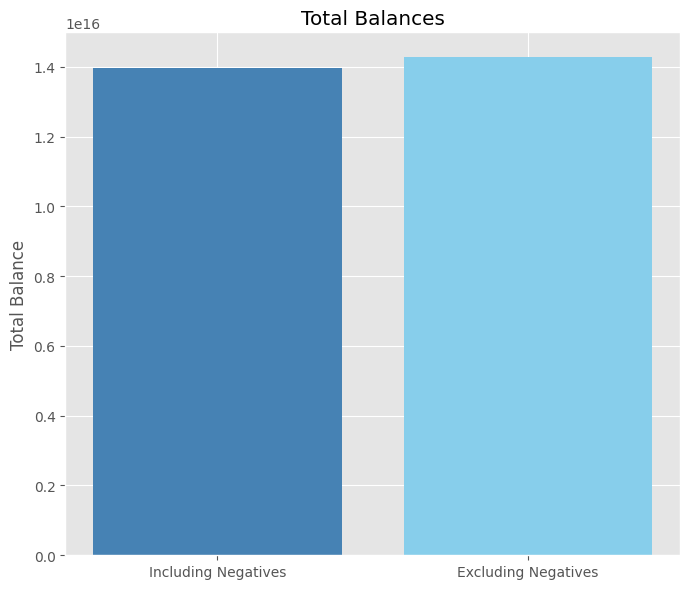

In [17]:
# Calculate total balances
total_balance_all = sum(address_balances.values())
negative_balance_addresses = {address: balance for address, balance in address_balances.items() if balance < 0}

# Exclude negative balances for further analysis
positive_address_balances = {address: balance for address, balance in address_balances.items() if balance >= 0}
total_balance_positive = sum(positive_address_balances.values())

# Print the results
print("Impact Analysis:")
print(f"Total balance (including negatives): {total_balance_all}")
print(f"Total balance (excluding negatives): {total_balance_positive}")

# Visualization of total balances
fig, ax = plt.subplots(figsize=(7, 6))

# Bar chart of total balances
ax.bar(['Including Negatives', 'Excluding Negatives'], [total_balance_all, total_balance_positive], color=['steelblue', 'skyblue'])
ax.set_title('Total Balances')
ax.set_ylabel('Total Balance')

plt.tight_layout()
plt.show()

conn.close()

In [18]:
print(negative_balance_addresses)

{'22a98444cebb7b6938f5bb44bf3df90fcd2af3a7d2c7c55347a251a228c85e46': -1710000000.0, '7d357d0655fabf7eedad8eedcc782d5edaa9673518ef61d6df2c3eed498d24ee': -647000000.0, '9fc47711f33a65159a48166c2771f64b437f71900e25462f0e95f33370285348': -135000000.0, 'd889f794734f4654669a1c51bbc7487631713bb454b655f2e0fc91e558e2a00f': -466002274.0, '5a11e358278148d43bc0b98d96e1768dbb5fc3a01267e6728d60b269a5ce6fbe': -188541490070.0, '0a317ee971bcdd4fd5bb5719167b592f238431f5148966e3bad50490cc1d301f': -380616000.0, '4a956e1b10b766281a42dede35bb0833edcff0a81148ecc04402986df16c721c': -11325000000.0, '7440a6293b83a000d90781525bf69e281f79013a5990eb066edc44ccd8d772f3': -903014998.0, '0c905341a437e12fcec058dd43ec5b554ed8edad45ba90c8ac3df834d007f805': -1480281000.0, '02b0ab655312f42e7bf52d84e6230ef425b3ac77e64d6e9a6e50d1781d705875': -1150.0, '0f4af482b2c58a931e2e1ebbe76e473bbc1691c76bf26c5521d58f4bb8e1d8f2': -4000000.0, '2f8e43d954ffcf951148fcf49f38368e1f6069371baa01be11f42f826546b564': -46939628530455.0, '31f6d1a70

# Saving all the negative Addresses into the csv file with


In [21]:
negative_addresses_df = pd.DataFrame(list(negative_balance_addresses.items()), columns= ['address','balances'])
negative_addresses_df.to_csv('negative_balance_addresses.csv', index=False)
